# <span style="font-size:36px; color:orange;">Group project ✌🏻</span>

# <span style="font-size:36px; color:orange;">Data Mining Analysis Report on Amazon Product Data</span>

Scraping keyword: laptop
  Records scraped for 'laptop': 162
Scraping keyword: notebook
  Records scraped for 'notebook': 300
Scraping keyword: ultrabook
  Records scraped for 'ultrabook': 130
Total combined records after removing duplicates: 507


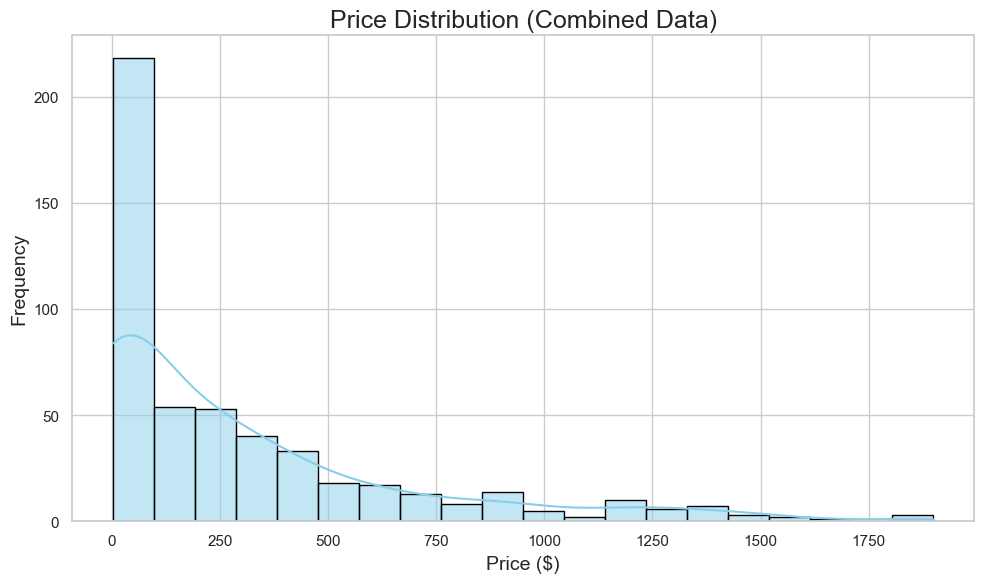

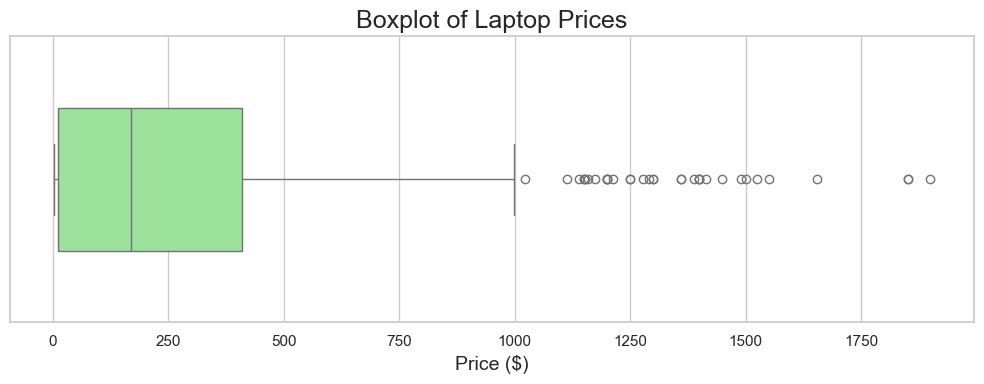

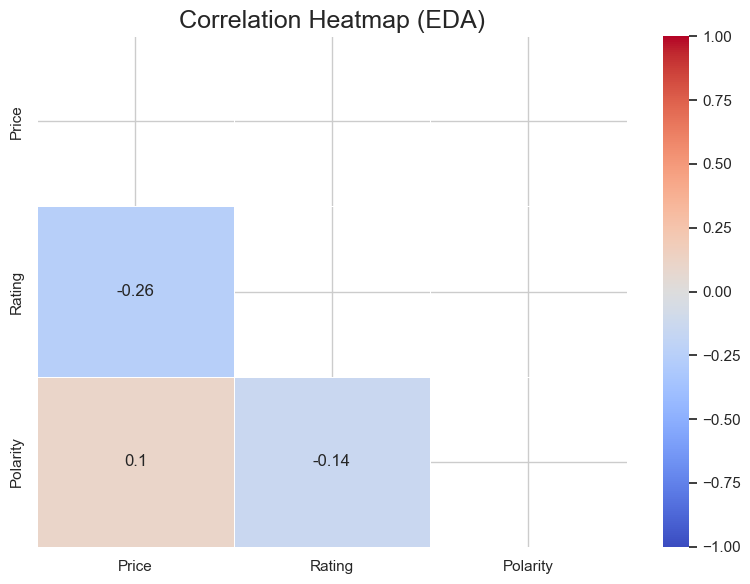

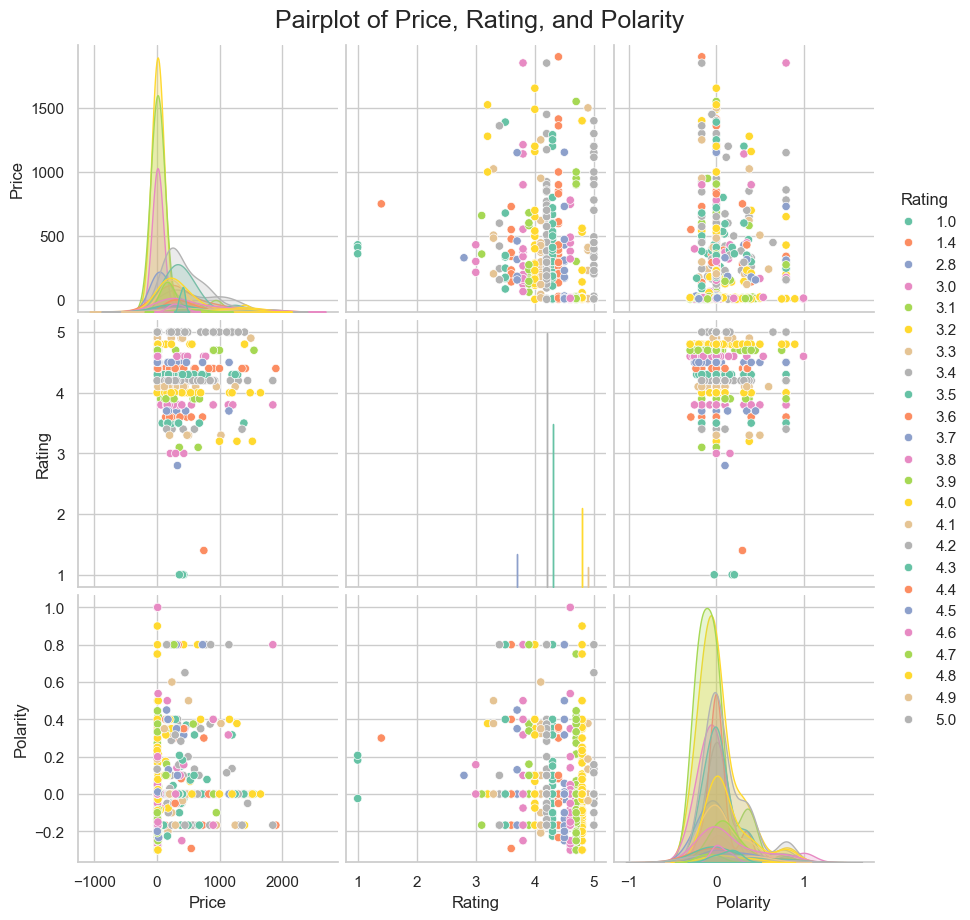

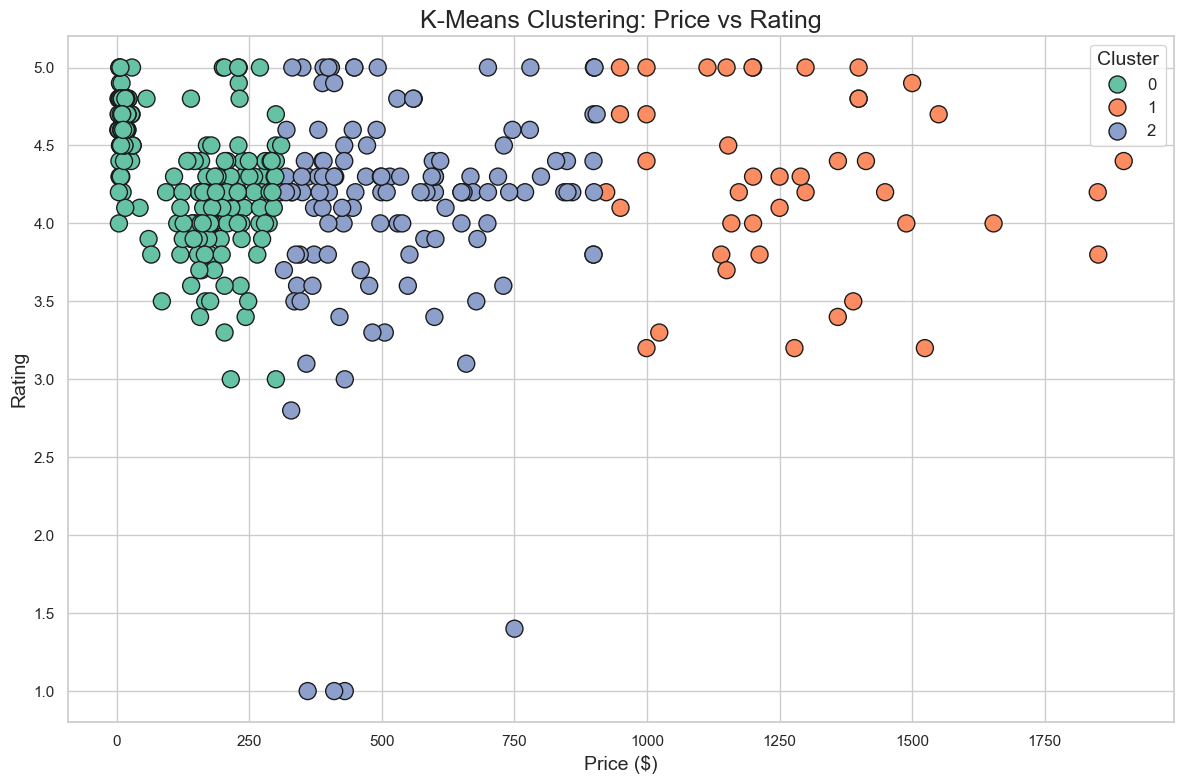

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best Decision Tree Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5}
Decision Tree Performance:
  Accuracy:  0.82
  Precision: 0.79
  Recall:    0.71
  F1-Score:  0.75


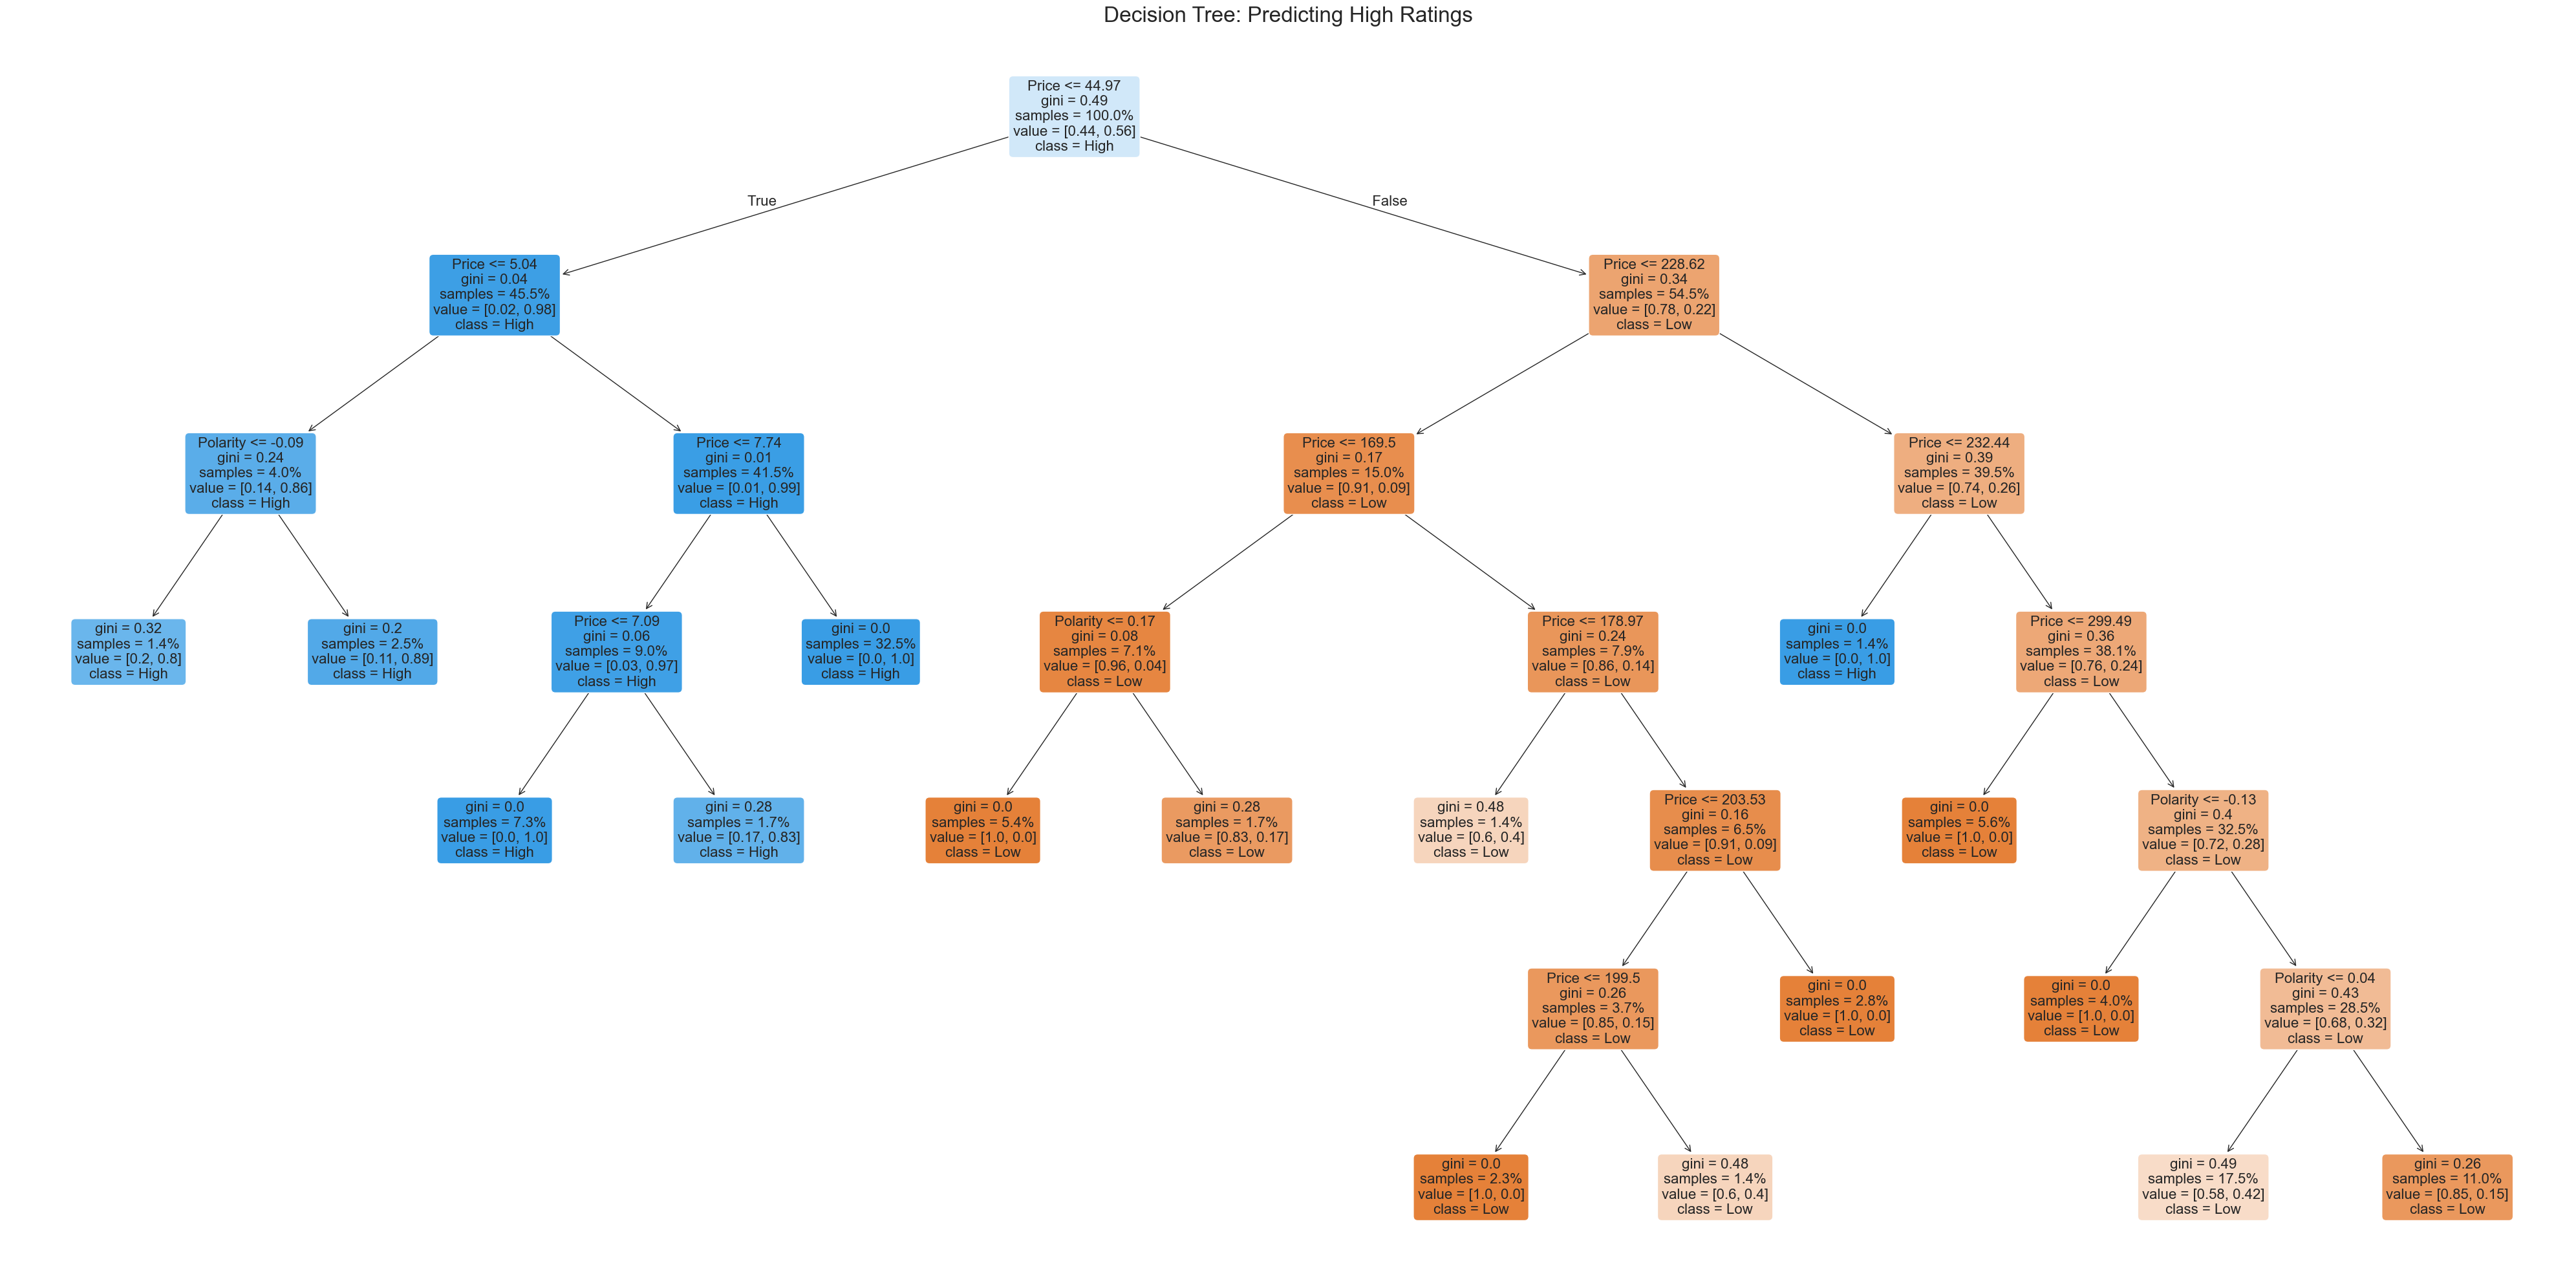


Correlation Matrix:
             Price    Rating  Polarity
Price     1.000000 -0.255302  0.101797
Rating   -0.255302  1.000000 -0.143833
Polarity  0.101797 -0.143833  1.000000


In [8]:
# -----------------------------------------------------------
# 1. Import Libraries
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# For web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import random

# For machine learning
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -----------------------------------------------------------
# 2. Set Up Visualization Style
# -----------------------------------------------------------
sns.set_theme(style="whitegrid")

# -----------------------------------------------------------
# 3. Define the Web Crawling Function
# -----------------------------------------------------------
def scrape_amazon(keyword="laptop", max_pages=5):
    """
    Scrapes Amazon search results for a given keyword across multiple pages.
    Returns a pandas DataFrame with columns: Title, Price, Rating, Polarity.
    """
    # Set up headless Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    products = []  # List to store product info

    # Loop through pages
    for page in range(1, max_pages + 1):
        url = f"https://www.amazon.com/s?k={keyword}&page={page}"
        driver.get(url)
        time.sleep(random.uniform(2, 5))  # Random delay to mimic human browsing

        soup = BeautifulSoup(driver.page_source, "html.parser")
        items = soup.select("div.s-main-slot div[data-component-type='s-search-result']")
        
        for item in items:
            # Extract product title
            title_tag = item.h2
            title = title_tag.text.strip() if title_tag else "N/A"
            
            # Extract product price
            price_tag = item.select_one("span.a-price > span.a-offscreen")
            try:
                price = float(price_tag.text.replace("$", "").replace(",", "")) if price_tag else None
            except:
                price = None
            
            # Extract product rating
            rating_tag = item.select_one("span.a-icon-alt")
            try:
                rating = float(rating_tag.text.split()[0]) if rating_tag else None
            except:
                rating = None
            
            # Calculate sentiment polarity from the title
            polarity = TextBlob(title).sentiment.polarity
            
            # Only add valid entries
            if price and rating:
                products.append({
                    "Title": title,
                    "Price": price,
                    "Rating": rating,
                    "Polarity": polarity
                })
                
    driver.quit()
    return pd.DataFrame(products)

# -----------------------------------------------------------
# 4. Crawl Data from the Web
# -----------------------------------------------------------
# For this project, we are using products other than "headphones".
keywords = ["laptop", "notebook", "ultrabook"]
df_list = []

for kw in keywords:
    print(f"Scraping keyword: {kw}")
    temp_df = scrape_amazon(keyword=kw, max_pages=10)  # Increase pages to get more data
    print(f"  Records scraped for '{kw}': {len(temp_df)}")
    df_list.append(temp_df)

# Combine dataframes and remove duplicates
df = pd.concat(df_list, ignore_index=True)
df.drop_duplicates(subset=["Title", "Price", "Rating"], inplace=True)
print("Total combined records after removing duplicates:", len(df))

# -----------------------------------------------------------
# 5. Define Research Questions
# -----------------------------------------------------------
# Our research questions for this group project are:
# Q1: What clusters exist among the products based on Price and Rating?
# Q2: Can we predict whether a product will have a high rating using Price and Sentiment Polarity?
# Q3: What are the relationships (correlations) among Price, Rating, and Sentiment Polarity?
#
# These questions will guide our exploratory data analysis and data mining modeling.

# -----------------------------------------------------------
# 6. Exploratory Data Analysis (EDA)
# -----------------------------------------------------------
# Histogram: Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=20, kde=True, color="skyblue", edgecolor="black")
plt.title("Price Distribution (Combined Data)", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Boxplot: Price Outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["Price"], color="lightgreen", width=0.5)
plt.title("Boxplot of Laptop Prices", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation Heatmap: Relationships among variables
corr = df[["Price", "Rating", "Polarity"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (EDA)", fontsize=18)
plt.tight_layout()
plt.show()

# Pairplot: Visualizing pairwise relationships
sns.pairplot(df, vars=["Price", "Rating", "Polarity"], hue="Rating", palette="Set2", height=3, diag_kind="kde")
plt.suptitle("Pairplot of Price, Rating, and Polarity", y=1.02, fontsize=18)
plt.show()

# -----------------------------------------------------------
# 7. Data Mining Models to Answer Research Questions
# -----------------------------------------------------------

# -------------------------------
# Q1: Clustering (K-Means)
# -------------------------------
# Apply K-Means clustering on Price and Rating to see if natural groupings exist.
df_clean = df.dropna(subset=["Price", "Rating"])  # Remove missing values if any

kmeans = KMeans(n_clusters=3, random_state=42)
df_clean["Cluster"] = kmeans.fit_predict(df_clean[["Price", "Rating"]])

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_clean, x="Price", y="Rating", 
    hue="Cluster", palette="Set2", s=150, edgecolor="k"
)
plt.title("K-Means Clustering: Price vs Rating", fontsize=18)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Rating", fontsize=14)
plt.legend(title="Cluster", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Insight:
# Clustering helps us identify distinct product segments. For example,
# one cluster may represent high-priced, high-rated products while another
# may capture lower-priced items with moderate ratings.

# -------------------------------
# Q2: Decision Tree Classification
# -------------------------------
# Our goal is to predict if a product will have a high rating.
# Define HighRating as 1 if Rating >= 4.5, else 0.
df_clean["HighRating"] = (df_clean["Rating"] >= 4.5).astype(int)

# Features: Price and Sentiment Polarity
X = df_clean[["Price", "Polarity"]]
y = df_clean["HighRating"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up a parameter grid for hyperparameter tuning of the decision tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 7, None],
    'min_samples_leaf': [1, 2, 3, 5, 10],
    'class_weight': [None, 'balanced']
}

dtree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
print("Best Decision Tree Parameters:", grid_search.best_params_)

y_pred = best_tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("Decision Tree Performance:")
print(f"  Accuracy:  {acc:.2f}")
print(f"  Precision: {prec:.2f}")
print(f"  Recall:    {rec:.2f}")
print(f"  F1-Score:  {f1_val:.2f}")

# ----------- UPDATED SECTION TO AVOID OVERLAPPING TEXT -----------
# Plot the decision tree using a very large figure and large font to ensure readability.
plt.figure(figsize=(40, 20))  # Significantly larger figure size
plot_tree(
    best_tree,
    feature_names=["Price", "Polarity"],
    class_names=["Low", "High"],
    filled=True,
    rounded=True,
    fontsize=16,      # Large font size as requested
    proportion=True,  # Scale boxes by sample proportion
    precision=2       # Round numeric values to 2 decimals
)
plt.title("Decision Tree: Predicting High Ratings", fontsize=24)
plt.tight_layout()
plt.show()
# ---------------------------------------------------------------

# Insight:
# The decision tree shows how Price and Polarity can help predict a high rating.
# Although our prediction is not perfect, the model reveals important thresholds and relationships,
# leading to a deeper understanding of product performance.

# -------------------------------
# Q3: Correlation Analysis
# -------------------------------
# Print the correlation matrix to quantify relationships.
print("\nCorrelation Matrix:")
print(df_clean[["Price", "Rating", "Polarity"]].corr())

# Insight:
# For example, a strong positive correlation between Price and Rating or
# a negative correlation between Price and Polarity may reveal trends in the data,
# helping to answer questions about market segmentation and customer sentiment.

# -----------------------------------------------------------
# 8. Summary of Knowledge Gained
# -----------------------------------------------------------
# Through this analysis:
# - Clustering reveals natural segments among products (e.g., budget vs. premium).
# - The decision tree model, while not perfect, helps identify key factors that
#   influence high ratings, offering actionable thresholds.
# - Correlation analysis enhances our understanding of how price, rating,
#   and sentiment interact.
#
# Even if our models do not answer all questions definitively, they significantly
# advance our knowledge about product characteristics and customer behavior,
# illustrating the power of data mining in uncovering hidden insights.


# <span style="font-size:36px; color:orange;">3D K-mean clustering  with standardization and K-Means clustering with standardization ⬇️ </span>

# <span style="font-size:36px; color:orange;">I tested 3D clustering and standardization, both reduced clarity; thus, I retained the original 2D model for better interpretability and practical value.</span>

NumPy version: 1.26.0
Scraping keyword: laptop
  Records scraped for 'laptop': 79
Scraping keyword: notebook
  Records scraped for 'notebook': 234
Scraping keyword: ultrabook
  Records scraped for 'ultrabook': 68
Total combined records after removing duplicates: 317


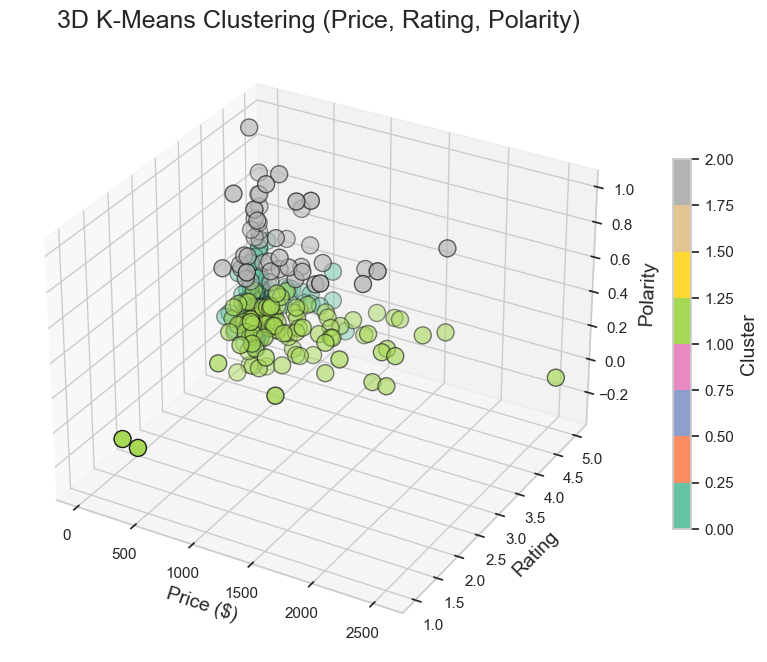

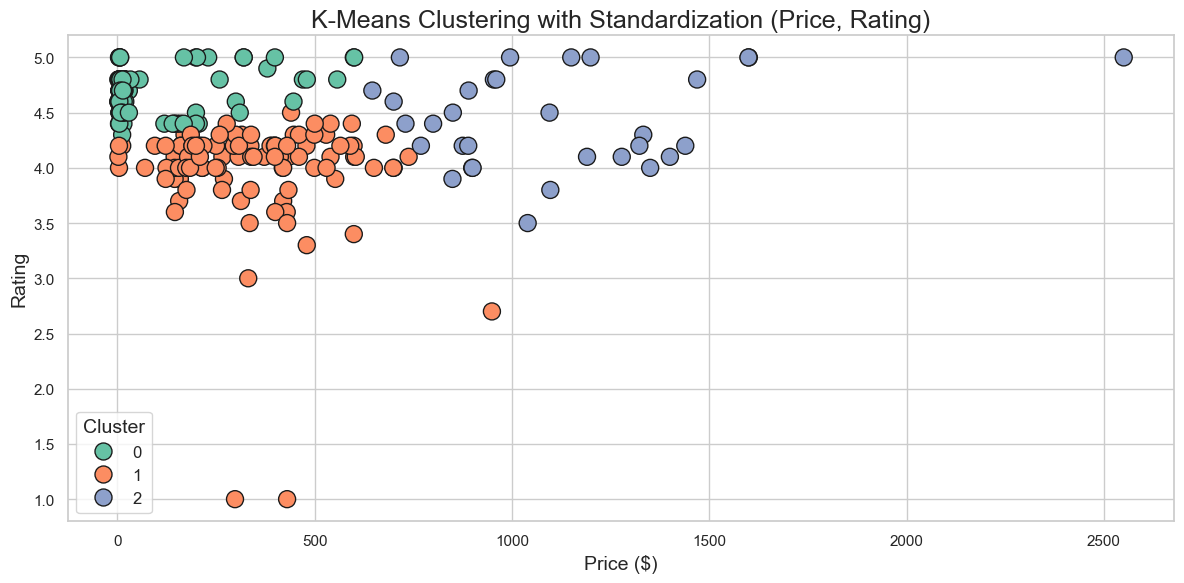

In [11]:
# -----------------------------------------------------------
# 1. Import Libraries and Check Versions
# -----------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from textblob import TextBlob

# For web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# For machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# For 3D visualization
from mpl_toolkits.mplot3d import Axes3D

print("NumPy version:", np.__version__)
if not hasattr(np, "_ARRAY_API"):
    print("Warning: _ARRAY_API not found. Consider upgrading numpy (pip install --upgrade numpy) to avoid compatibility issues.")

# Set the seaborn visualization theme for the 2D plot
sns.set_theme(style="whitegrid")

# -----------------------------------------------------------
# 2. Define the Amazon Scraping Function
# -----------------------------------------------------------
def scrape_amazon(keyword="laptop", max_pages=5):
    """
    Scrapes Amazon search results for a given keyword across multiple pages.
    Returns a pandas DataFrame with columns: Title, Price, Rating, Polarity.
    """
    # Configure headless Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    products = []  # List to store product information

    # Loop through pages for the given keyword
    for page in range(1, max_pages + 1):
        url = f"https://www.amazon.com/s?k={keyword}&page={page}"
        driver.get(url)
        time.sleep(random.uniform(2, 5))  # Random delay to mimic human browsing

        soup = BeautifulSoup(driver.page_source, "html.parser")
        items = soup.select("div.s-main-slot div[data-component-type='s-search-result']")
        
        for item in items:
            # Extract product title
            title_tag = item.h2
            title = title_tag.text.strip() if title_tag else "N/A"
            
            # Extract product price
            price_tag = item.select_one("span.a-price > span.a-offscreen")
            try:
                price = float(price_tag.text.replace("$", "").replace(",", "")) if price_tag else None
            except Exception:
                price = None
            
            # Extract product rating
            rating_tag = item.select_one("span.a-icon-alt")
            try:
                rating = float(rating_tag.text.split()[0]) if rating_tag else None
            except Exception:
                rating = None
            
            # Calculate sentiment polarity from the title using TextBlob
            polarity = TextBlob(title).sentiment.polarity
            
            # Add the product only if both price and rating are available
            if price is not None and rating is not None:
                products.append({
                    "Title": title,
                    "Price": price,
                    "Rating": rating,
                    "Polarity": polarity
                })
                
    driver.quit()
    return pd.DataFrame(products)

# -----------------------------------------------------------
# 3. Main Process: Data Crawl and Clustering
# -----------------------------------------------------------
def main():
    # Define keywords to scrape from Amazon
    keywords = ["laptop", "notebook", "ultrabook"]
    df_list = []
    
    # Scrape data for each keyword
    for kw in keywords:
        print(f"Scraping keyword: {kw}")
        temp_df = scrape_amazon(keyword=kw, max_pages=5)  # You may adjust max_pages for more data
        print(f"  Records scraped for '{kw}': {len(temp_df)}")
        df_list.append(temp_df)
    
    # Combine the dataframes and remove duplicates based on Title, Price, and Rating
    df = pd.concat(df_list, ignore_index=True)
    df.drop_duplicates(subset=["Title", "Price", "Rating"], inplace=True)
    print("Total combined records after removing duplicates:", len(df))
    
    # Clean the data: Remove rows with missing values in any of the key columns
    df_clean = df.dropna(subset=["Price", "Rating", "Polarity"])
    
    # -----------------------
    # 3A. 3D K-Means Clustering on Price, Rating, and Polarity
    # -----------------------
    # Extract features for 3D clustering and standardize them
    features_3d = df_clean[["Price", "Rating", "Polarity"]]
    scaler_3d = StandardScaler()
    scaled_features_3d = scaler_3d.fit_transform(features_3d)
    
    # Apply K-Means clustering with 3 clusters
    kmeans_3d = KMeans(n_clusters=3, random_state=42)
    df_clean["Cluster_3d"] = kmeans_3d.fit_predict(scaled_features_3d)
    
    # Create a 3D scatter plot for the clusters
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        df_clean["Price"],
        df_clean["Rating"],
        df_clean["Polarity"],
        c=df_clean["Cluster_3d"],
        cmap="Set2",
        s=150,
        edgecolor="k"
    )
    ax.set_xlabel("Price ($)", fontsize=14)
    ax.set_ylabel("Rating", fontsize=14)
    ax.set_zlabel("Polarity", fontsize=14)
    ax.set_title("3D K-Means Clustering (Price, Rating, Polarity)", fontsize=18)
    cb = fig.colorbar(scatter, ax=ax, shrink=0.6)
    cb.set_label("Cluster", fontsize=14)
    plt.show()
    
    # -----------------------
    # 3B. 2D K-Means Clustering with Standardization on Price and Rating
    # -----------------------
    # Extract features for 2D clustering and standardize them
    features_2d = df_clean[["Price", "Rating"]]
    scaler_2d = StandardScaler()
    scaled_features_2d = scaler_2d.fit_transform(features_2d)
    
    # Apply K-Means clustering with 3 clusters
    kmeans_2d = KMeans(n_clusters=3, random_state=42)
    df_clean["Cluster_Std"] = kmeans_2d.fit_predict(scaled_features_2d)
    
    # Create a 2D scatter plot using Seaborn for the standardized clusters
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df_clean,
        x="Price",
        y="Rating",
        hue="Cluster_Std",
        palette="Set2",
        s=150,
        edgecolor="k"
    )
    plt.title("K-Means Clustering with Standardization (Price, Rating)", fontsize=18)
    plt.xlabel("Price ($)", fontsize=14)
    plt.ylabel("Rating", fontsize=14)
    plt.legend(title="Cluster", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
